# Swiss Tweet Votations

In [17]:
import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import folium as fol
import seaborn as sns
sns.set()

%matplotlib inline

## Data retrieving
Since we want to focus on one particular event, we don't need to work on the complete dataset. We download the tweets from the cluster to be able to work on them remotely.

In [2]:
# Download the dataset from Hadoop

import glob
from os.path import basename, splitext
import requests as rx
from urllib.request import urlretrieve
from time import sleep

swiss_tweet_url = 'http://iccluster060.iccluster.epfl.ch:50070/webhdfs/v1/datasets/swiss-tweet'
operation_list = '?op=LISTSTATUS'
operation_open = '?op=OPEN'

req = rx.get(swiss_tweet_url + operation_list)
if req.status_code != 200:
    raise Exception("Failed to load list of files")

remote_swiss_tweet_files = set(map(lambda f: f['pathSuffix'], req.json()['FileStatuses']['FileStatus']))
local_swiss_tweet_files = set(map(lambda f: basename(f), glob.glob('data/harvest3r_twitter_data_*.json')))

missing_swiss_tweet_files = remote_swiss_tweet_files - local_swiss_tweet_files
missing_index, missing_count = 0, len(missing_swiss_tweet_files)

if missing_count == 0:
    print("Your dataset is complete, nothing to download!")

for swiss_tweet_file in missing_swiss_tweet_files:
    missing_index += 1
    print("Downloading {} ({} of {} files)".format(swiss_tweet_file, missing_index, missing_count))
    
    frm = swiss_tweet_url + '/' + swiss_tweet_file + operation_open
    to = 'data/' + swiss_tweet_file
    
    urlretrieve(frm, to)
    sleep(1)

Your dataset is complete, nothing to download!


## Preprocessing: Filtering

As we only want tweets containing hashtags, we keep only those and save them so there are less tweets to process afterwards.

In [9]:
i = 0
datasets = glob.glob('data/harvest3r_twitter_data_*.json')
for datapath in datasets:
    i += 1
    print("Working on file {} of {}: {}".format(i, len(datasets), datapath))
    tweets = pd.DataFrame( pd.read_json(datapath)._source.tolist() )
    tagged_tweets = tweets.dropna(subset=['tags'])
    tagged_tweets.tags = tagged_tweets.tags.apply(lambda ts: set([t.lower() for t in ts]))
    print("Amount of tagged tweets found: {}".format(tagged_tweets.main.size))
    taggedpath = 'data/tagged_' + splitext(basename(datapath))[0] + '.json'
    print("Tagged tweets written to: {}".format(taggedpath))
    tagged_tweets.to_json(taggedpath)

Working on file 1 of 302: data/harvest3r_twitter_data_07-05_0.json


/home/cranium/.anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Amount of tagged tweets found: 6929
Tagged tweets written to: data/tagged_harvest3r_twitter_data_07-05_0.json
Working on file 2 of 302: data/harvest3r_twitter_data_29-06_0.json
Amount of tagged tweets found: 4396
Tagged tweets written to: data/tagged_harvest3r_twitter_data_29-06_0.json
Working on file 3 of 302: data/harvest3r_twitter_data_27-01_0.json
Amount of tagged tweets found: 8562
Tagged tweets written to: data/tagged_harvest3r_twitter_data_27-01_0.json
Working on file 4 of 302: data/harvest3r_twitter_data_12-08_0.json
Amount of tagged tweets found: 16181
Tagged tweets written to: data/tagged_harvest3r_twitter_data_12-08_0.json
Working on file 5 of 302: data/harvest3r_twitter_data_10-03_0.json
Amount of tagged tweets found: 7199
Tagged tweets written to: data/tagged_harvest3r_twitter_data_10-03_0.json
Working on file 6 of 302: data/harvest3r_twitter_data_14-01_0.json
Amount of tagged tweets found: 7900
Tagged tweets written to: data/tagged_harvest3r_twitter_data_14-01_0.json
Work

Amount of tagged tweets found: 3990
Tagged tweets written to: data/tagged_harvest3r_twitter_data_24-04_0.json
Working on file 48 of 302: data/harvest3r_twitter_data_12-06_0.json
Amount of tagged tweets found: 5688
Tagged tweets written to: data/tagged_harvest3r_twitter_data_12-06_0.json
Working on file 49 of 302: data/harvest3r_twitter_data_01-05_0.json
Amount of tagged tweets found: 5754
Tagged tweets written to: data/tagged_harvest3r_twitter_data_01-05_0.json
Working on file 50 of 302: data/harvest3r_twitter_data_13-03_0.json
Amount of tagged tweets found: 3622
Tagged tweets written to: data/tagged_harvest3r_twitter_data_13-03_0.json
Working on file 51 of 302: data/harvest3r_twitter_data_20-07_0.json
Amount of tagged tweets found: 16655
Tagged tweets written to: data/tagged_harvest3r_twitter_data_20-07_0.json
Working on file 52 of 302: data/harvest3r_twitter_data_27-09_0.json
Amount of tagged tweets found: 17722
Tagged tweets written to: data/tagged_harvest3r_twitter_data_27-09_0.jso

Amount of tagged tweets found: 7416
Tagged tweets written to: data/tagged_harvest3r_twitter_data_12-04_0.json
Working on file 94 of 302: data/harvest3r_twitter_data_24-02_0.json
Amount of tagged tweets found: 6910
Tagged tweets written to: data/tagged_harvest3r_twitter_data_24-02_0.json
Working on file 95 of 302: data/harvest3r_twitter_data_13-06_0.json
Amount of tagged tweets found: 8040
Tagged tweets written to: data/tagged_harvest3r_twitter_data_13-06_0.json
Working on file 96 of 302: data/harvest3r_twitter_data_05-02_0.json
Amount of tagged tweets found: 7267
Tagged tweets written to: data/tagged_harvest3r_twitter_data_05-02_0.json
Working on file 97 of 302: data/harvest3r_twitter_data_14-10_0.json
Amount of tagged tweets found: 16818
Tagged tweets written to: data/tagged_harvest3r_twitter_data_14-10_0.json
Working on file 98 of 302: data/harvest3r_twitter_data_21-02_0.json
Amount of tagged tweets found: 5113
Tagged tweets written to: data/tagged_harvest3r_twitter_data_21-02_0.json

Amount of tagged tweets found: 5541
Tagged tweets written to: data/tagged_harvest3r_twitter_data_04-06_0.json
Working on file 140 of 302: data/harvest3r_twitter_data_25-03_0.json
Amount of tagged tweets found: 5482
Tagged tweets written to: data/tagged_harvest3r_twitter_data_25-03_0.json
Working on file 141 of 302: data/harvest3r_twitter_data_13-04_0.json
Amount of tagged tweets found: 6973
Tagged tweets written to: data/tagged_harvest3r_twitter_data_13-04_0.json
Working on file 142 of 302: data/harvest3r_twitter_data_01-08_0.json
Amount of tagged tweets found: 9478
Tagged tweets written to: data/tagged_harvest3r_twitter_data_01-08_0.json
Working on file 143 of 302: data/harvest3r_twitter_data_11-01_0.json
Amount of tagged tweets found: 2786
Tagged tweets written to: data/tagged_harvest3r_twitter_data_11-01_0.json
Working on file 144 of 302: data/harvest3r_twitter_data_02-08_0.json
Amount of tagged tweets found: 8313
Tagged tweets written to: data/tagged_harvest3r_twitter_data_02-08_0.

Amount of tagged tweets found: 6772
Tagged tweets written to: data/tagged_harvest3r_twitter_data_01-03_0.json
Working on file 186 of 302: data/harvest3r_twitter_data_26-07_0.json
Amount of tagged tweets found: 8397
Tagged tweets written to: data/tagged_harvest3r_twitter_data_26-07_0.json
Working on file 187 of 302: data/harvest3r_twitter_data_06-01_0.json
Amount of tagged tweets found: 5221
Tagged tweets written to: data/tagged_harvest3r_twitter_data_06-01_0.json
Working on file 188 of 302: data/harvest3r_twitter_data_30-10_0.json
Amount of tagged tweets found: 25273
Tagged tweets written to: data/tagged_harvest3r_twitter_data_30-10_0.json
Working on file 189 of 302: data/harvest3r_twitter_data_20-06_0.json
Amount of tagged tweets found: 6719
Tagged tweets written to: data/tagged_harvest3r_twitter_data_20-06_0.json
Working on file 190 of 302: data/harvest3r_twitter_data_29-07_0.json
Amount of tagged tweets found: 9088
Tagged tweets written to: data/tagged_harvest3r_twitter_data_29-07_0

Amount of tagged tweets found: 8001
Tagged tweets written to: data/tagged_harvest3r_twitter_data_27-04_0.json
Working on file 232 of 302: data/harvest3r_twitter_data_07-08_0.json
Amount of tagged tweets found: 12003
Tagged tweets written to: data/tagged_harvest3r_twitter_data_07-08_0.json
Working on file 233 of 302: data/harvest3r_twitter_data_25-09_0.json
Amount of tagged tweets found: 13228
Tagged tweets written to: data/tagged_harvest3r_twitter_data_25-09_0.json
Working on file 234 of 302: data/harvest3r_twitter_data_30-07_0.json
Amount of tagged tweets found: 5681
Tagged tweets written to: data/tagged_harvest3r_twitter_data_30-07_0.json
Working on file 235 of 302: data/harvest3r_twitter_data_23-04_0.json
Amount of tagged tweets found: 4040
Tagged tweets written to: data/tagged_harvest3r_twitter_data_23-04_0.json
Working on file 236 of 302: data/harvest3r_twitter_data_03-07_0.json
Amount of tagged tweets found: 3663
Tagged tweets written to: data/tagged_harvest3r_twitter_data_03-07_

Amount of tagged tweets found: 6482
Tagged tweets written to: data/tagged_harvest3r_twitter_data_25-02_0.json
Working on file 278 of 302: data/harvest3r_twitter_data_22-03_0.json
Amount of tagged tweets found: 7656
Tagged tweets written to: data/tagged_harvest3r_twitter_data_22-03_0.json
Working on file 279 of 302: data/harvest3r_twitter_data_04-02_0.json
Amount of tagged tweets found: 2296
Tagged tweets written to: data/tagged_harvest3r_twitter_data_04-02_0.json
Working on file 280 of 302: data/harvest3r_twitter_data_03-04_0.json
Amount of tagged tweets found: 4783
Tagged tweets written to: data/tagged_harvest3r_twitter_data_03-04_0.json
Working on file 281 of 302: data/harvest3r_twitter_data_14-05_0.json
Amount of tagged tweets found: 9709
Tagged tweets written to: data/tagged_harvest3r_twitter_data_14-05_0.json
Working on file 282 of 302: data/harvest3r_twitter_data_02-06_0.json
Amount of tagged tweets found: 7854
Tagged tweets written to: data/tagged_harvest3r_twitter_data_02-06_0.

## Preprocessing: Exploration

First of all, we need to discover hashtags used for the votations. We begin our search by finding all tweets tagged #chvote, a popular hashtag when votations are around the corner. We will then count every other hashtags associated – in general, the subject of the votation is also in the hashtags.

In [10]:
i = 0
chvote_tweets = pd.DataFrame()
datasets = glob.glob('data/tagged_harvest3r_twitter_data_*.json')
for datapath in datasets:
    i += 1
    print("Working on file {} of {}: {}".format(i, len(datasets), datapath))
    tweets = pd.read_json(datapath)
    tweets_found = tweets.select(lambda t: 'chvote' in tweets.loc[t].tags)
    print("Amount of #chvote found: {} / {}".format(tweets_found.main.size, tweets.main.size))
    chvote_tweets = chvote_tweets.append(tweets_found, ignore_index=True)
    
chvotepath = 'data/tweets-chvote.json'
print("Tweets #chvote written to: ", chvotepath)
chvote_tweets.to_json(chvotepath)

Working on file 1 of 302: data/tagged_harvest3r_twitter_data_16-07_0.json
Amount of #chvote found: 0 / 8253
Working on file 2 of 302: data/tagged_harvest3r_twitter_data_14-02_0.json
Amount of #chvote found: 3 / 5403
Working on file 3 of 302: data/tagged_harvest3r_twitter_data_25-04_0.json
Amount of #chvote found: 9 / 6015
Working on file 4 of 302: data/tagged_harvest3r_twitter_data_20-02_0.json
Amount of #chvote found: 3 / 5573
Working on file 5 of 302: data/tagged_harvest3r_twitter_data_09-06_0.json
Amount of #chvote found: 1 / 5630
Working on file 6 of 302: data/tagged_harvest3r_twitter_data_21-07_0.json
Amount of #chvote found: 3 / 6601
Working on file 7 of 302: data/tagged_harvest3r_twitter_data_29-03_0.json
Amount of #chvote found: 2 / 6738
Working on file 8 of 302: data/tagged_harvest3r_twitter_data_02-07_0.json
Amount of #chvote found: 1 / 5027
Working on file 9 of 302: data/tagged_harvest3r_twitter_data_28-04_0.json
Amount of #chvote found: 7 / 7595
Working on file 10 of 302: d

Amount of #chvote found: 6 / 5923
Working on file 77 of 302: data/tagged_harvest3r_twitter_data_10-05_0.json
Amount of #chvote found: 7 / 9170
Working on file 78 of 302: data/tagged_harvest3r_twitter_data_15-02_0.json
Amount of #chvote found: 14 / 6299
Working on file 79 of 302: data/tagged_harvest3r_twitter_data_17-03_0.json
Amount of #chvote found: 1 / 7268
Working on file 80 of 302: data/tagged_harvest3r_twitter_data_01-07_0.json
Amount of #chvote found: 1 / 6250
Working on file 81 of 302: data/tagged_harvest3r_twitter_data_18-08_0.json
Amount of #chvote found: 10 / 16659
Working on file 82 of 302: data/tagged_harvest3r_twitter_data_23-04_0.json
Amount of #chvote found: 3 / 4040
Working on file 83 of 302: data/tagged_harvest3r_twitter_data_09-01_0.json
Amount of #chvote found: 0 / 1818
Working on file 84 of 302: data/tagged_harvest3r_twitter_data_05-05_0.json
Amount of #chvote found: 13 / 5939
Working on file 85 of 302: data/tagged_harvest3r_twitter_data_26-06_0.json
Amount of #chvo

Amount of #chvote found: 2 / 5893
Working on file 152 of 302: data/tagged_harvest3r_twitter_data_20-05_0.json
Amount of #chvote found: 30 / 7515
Working on file 153 of 302: data/tagged_harvest3r_twitter_data_28-06_0.json
Amount of #chvote found: 0 / 4869
Working on file 154 of 302: data/tagged_harvest3r_twitter_data_31-07_0.json
Amount of #chvote found: 0 / 5091
Working on file 155 of 302: data/tagged_harvest3r_twitter_data_02-10_0.json
Amount of #chvote found: 3 / 11572
Working on file 156 of 302: data/tagged_harvest3r_twitter_data_01-08_0.json
Amount of #chvote found: 0 / 9478
Working on file 157 of 302: data/tagged_harvest3r_twitter_data_15-03_0.json
Amount of #chvote found: 1 / 7216
Working on file 158 of 302: data/tagged_harvest3r_twitter_data_09-10_0.json
Amount of #chvote found: 3 / 11512
Working on file 159 of 302: data/tagged_harvest3r_twitter_data_22-07_0.json
Amount of #chvote found: 1 / 10345
Working on file 160 of 302: data/tagged_harvest3r_twitter_data_31-10_1.json
Amount

Amount of #chvote found: 7 / 7063
Working on file 227 of 302: data/tagged_harvest3r_twitter_data_13-10_0.json
Amount of #chvote found: 3 / 17209
Working on file 228 of 302: data/tagged_harvest3r_twitter_data_08-09_0.json
Amount of #chvote found: 20 / 16964
Working on file 229 of 302: data/tagged_harvest3r_twitter_data_21-05_0.json
Amount of #chvote found: 6 / 4805
Working on file 230 of 302: data/tagged_harvest3r_twitter_data_17-02_0.json
Amount of #chvote found: 36 / 7106
Working on file 231 of 302: data/tagged_harvest3r_twitter_data_01-03_0.json
Amount of #chvote found: 8 / 6772
Working on file 232 of 302: data/tagged_harvest3r_twitter_data_13-06_0.json
Amount of #chvote found: 4 / 8040
Working on file 233 of 302: data/tagged_harvest3r_twitter_data_27-05_0.json
Amount of #chvote found: 9 / 6715
Working on file 234 of 302: data/tagged_harvest3r_twitter_data_27-10_1.json
Amount of #chvote found: 8 / 7088
Working on file 235 of 302: data/tagged_harvest3r_twitter_data_05-02_0.json
Amount

Amount of #chvote found: 3 / 7192
Working on file 302 of 302: data/tagged_harvest3r_twitter_data_31-08_0.json
Amount of #chvote found: 21 / 17451
Tweets #chvote written to:  data/tweets-chvote.json


In [3]:
# Extract tags
chvote_tags = list()
for tags in chvote_tweets.tags:
    chvote_tags += [t for t in tags]

# Popular tags
chvote_tags = pd.Series(chvote_tags)
chvote_tags.value_counts().head(10)

NameError: name 'chvote_tweets' is not defined

## Preprocessing: selecting tweets with given tags

We found a list of popular tags associated with the votations (more info on these in the README): "Abst16", "AVSplus", "LRens", "RBI". For each of those, we create a separate json file containing only those, once again to ease distribution and reuse – each generated file is less than 10MB.

In [154]:
i = 0
votations = {
    #'abst16': {'abst16', 'abstimmung', 'abstimmungen', 'atomausstieg', 'atomausstiegja', 'atomausstiegsinitiative', 'ausstiegsinitiative', 'energiewende', 'sortirdunucleaire', 'atome', 'nucleaire', 'nucléaire'},
    'lrens': {'lrens', 'lrensnon', 'lrensoui', 'loirenseignement', 'lscpt', 'etatfouineur', 'saveprivacy', 'ndg', 'ndgnein', 'stopndg', 'ndgja', 'ndb', 'stopndb', 'src', 'bupf', 'surveillance', 'privacy'},
    'rbi': {'rbi', 'rbioui', 'rentabásicauniversal', 'revenuuniversel', 'ubi', 'basicincome', 'grundeinkommen', 'rbi16', 'rbi2016', 'revenudebase', 'revenuuniversel', 'allocationuniverselle'},
    'avsplus': {'avsplus', 'ahvplus', 'av2020', 'avs', 'ahv'},
}
tweets_by_votation = { votation: pd.DataFrame() for votation in votations.keys() }

# Collect tweets by tags
datasets = glob.glob('data/tagged_harvest3r_twitter_data_*.json')
for datapath in datasets:
    i += 1
    print("Working on file {} of {}: {}".format(i, len(datasets), datapath))
    tweets = pd.read_json(datapath)
    tweets.tags = tweets.tags.apply(lambda ts: set(ts))
    for votation, tags_set in votations.items():
        tweets_found = tweets.select(lambda t: len(tags_set & tweets.loc[t].tags) > 0)
        tweets_by_votation[votation] = tweets_by_votation[votation].append(tweets_found, ignore_index=True)
        print("Amount of #{} found: {} / {}".format(votation, tweets_found.main.size, tweets.main.size))
        print("Current amount of #{}: {}".format(votation, tweets_by_votation[votation].main.size))

# Write tweets for future uses
for tag, tweets_tag in tweets_by_tag.items():
    tagpath = "data/tweets-{}-full.json".format(tag)
    print("Writting {} tweets to {}".format(tweets_tag.main.size, tagpath))
    tweets_tag.to_json(tagpath)

Working on file 1 of 302: data/tagged_harvest3r_twitter_data_16-07_0.json
Amount of #lrens found: 6 / 8253
Current amount of #lrens: 6
Amount of #rbi found: 1 / 8253
Current amount of #rbi: 1
Amount of #avsplus found: 0 / 8253
Current amount of #avsplus: 0
Working on file 2 of 302: data/tagged_harvest3r_twitter_data_14-02_0.json
Amount of #lrens found: 1 / 5403
Current amount of #lrens: 7
Amount of #rbi found: 1 / 5403
Current amount of #rbi: 2
Amount of #avsplus found: 0 / 5403
Current amount of #avsplus: 0
Working on file 3 of 302: data/tagged_harvest3r_twitter_data_25-04_0.json
Amount of #lrens found: 1 / 6015
Current amount of #lrens: 8
Amount of #rbi found: 10 / 6015
Current amount of #rbi: 12
Amount of #avsplus found: 1 / 6015
Current amount of #avsplus: 1
Working on file 4 of 302: data/tagged_harvest3r_twitter_data_20-02_0.json
Amount of #lrens found: 3 / 5573
Current amount of #lrens: 11
Amount of #rbi found: 2 / 5573
Current amount of #rbi: 14
Amount of #avsplus found: 0 / 557

KeyboardInterrupt: 

In [13]:
# Display stats on collected tags
tags = ['abst16', 'avsplus', 'lrens', 'rbi']
for t in tags:
    ts = pd.read_json('data/tweets-{}.json'.format(t))
    ts = ts.dropna(subset=['main'])
    print("Tweets for {}: {}".format(t, ts.main.size))

Tweets for abst16: 3711
Tweets for avsplus: 354
Tweets for lrens: 487
Tweets for rbi: 409


The amount of tweets being pretty low, we need to find more of them. The issue is that a votation is referred with different hashtags, for instance the name of the law in different languages. Looking for only one of them means we miss some part of the discussions. Looking to the other tags associated with our first selection can indicate us which other hashtags has been used. We also made some research manually on Twitter to find the other hashtags. We decided to drop #avsplus and came came up with the following list for each votation:

In [14]:
i = 0
votations = {
    'abst16': {'abst16', 'abstimmung', 'abstimmungen', 'atomausstieg', 'atomausstiegja', 'atomausstiegsinitiative', 'ausstiegsinitiative', 'energiewende', 'sortirdunucleaire', 'atome', 'nucleaire', 'nucléaire'},
    'lrens': {'lrens', 'lrensnon', 'lrensoui', 'loirenseignement', 'lscpt', 'etatfouineur', 'saveprivacy', 'ndg', 'ndgnein', 'stopndg', 'ndgja', 'ndb', 'stopndb', 'src', 'bupf', 'surveillance', 'privacy'},
    'rbi': {'rbi', 'rbioui', 'rentabásicauniversal', 'revenuuniversel', 'ubi', 'basicincome', 'grundeinkommen', 'rbi16', 'rbi2016', 'revenudebase', 'revenuuniversel', 'allocationuniverselle'}
}
tweets_by_votation = { votation: pd.DataFrame() for votation in votations.keys() }

# Collect tweets by tags
datasets = glob.glob('data/tagged_harvest3r_twitter_data_*.json')
for datapath in datasets:
    i += 1
    print("Working on file {} of {}: {}".format(i, len(datasets), datapath))
    tweets = pd.read_json(datapath)
    for votation, tags_set in votations.items():
        tweets_found = tweets.select(lambda t: votation in tweets.loc[t].tags)
        tweets_tag = tweets_tag.append(tweets_found, ignore_index=True)
        print("Amount of #{} found: {} / {}".format(votation, tweets_found.main.size, tweets.main.size))
        print("Current amount of #{}: {}".format(votation, tweets_tag.main.size))

# Write tweets for future uses
for tag, tweets_tag in tweets_by_tag.items():
    tagpath = "data/tweets-{}-full.json".format(tag)
    print("Writting {} tweets to {}".format(tweets_tag.main.size, tagpath))
    tweets_tag.to_json(tagpath)

Working on file 1 of 302: data/tagged_harvest3r_twitter_data_16-07_0.json
Amount of #rbi found: 1 / 8253
Current amount of #rbi: 3712
Amount of #lrens found: 0 / 8253
Current amount of #lrens: 3712
Amount of #abst16 found: 0 / 8253
Current amount of #abst16: 3712
Working on file 2 of 302: data/tagged_harvest3r_twitter_data_14-02_0.json
Amount of #rbi found: 0 / 5403
Current amount of #rbi: 3712
Amount of #lrens found: 0 / 5403
Current amount of #lrens: 3712
Amount of #abst16 found: 7 / 5403
Current amount of #abst16: 3719
Working on file 3 of 302: data/tagged_harvest3r_twitter_data_25-04_0.json
Amount of #rbi found: 5 / 6015
Current amount of #rbi: 3724
Amount of #lrens found: 0 / 6015
Current amount of #lrens: 3724
Amount of #abst16 found: 1 / 6015
Current amount of #abst16: 3725
Working on file 4 of 302: data/tagged_harvest3r_twitter_data_20-02_0.json
Amount of #rbi found: 0 / 5573
Current amount of #rbi: 3725
Amount of #lrens found: 0 / 5573
Current amount of #lrens: 3725
Amount of 

Amount of #rbi found: 2 / 6973
Current amount of #rbi: 3928
Amount of #lrens found: 0 / 6973
Current amount of #lrens: 3928
Amount of #abst16 found: 2 / 6973
Current amount of #abst16: 3930
Working on file 33 of 302: data/tagged_harvest3r_twitter_data_21-04_0.json
Amount of #rbi found: 1 / 7133
Current amount of #rbi: 3931
Amount of #lrens found: 0 / 7133
Current amount of #lrens: 3931
Amount of #abst16 found: 0 / 7133
Current amount of #abst16: 3931
Working on file 34 of 302: data/tagged_harvest3r_twitter_data_05-04_0.json
Amount of #rbi found: 0 / 6800
Current amount of #rbi: 3931
Amount of #lrens found: 0 / 6800
Current amount of #lrens: 3931
Amount of #abst16 found: 5 / 6800
Current amount of #abst16: 3936
Working on file 35 of 302: data/tagged_harvest3r_twitter_data_10-01_0.json
Amount of #rbi found: 0 / 1859
Current amount of #rbi: 3936
Amount of #lrens found: 0 / 1859
Current amount of #lrens: 3936
Amount of #abst16 found: 0 / 1859
Current amount of #abst16: 3936
Working on file

Amount of #rbi found: 0 / 3865
Current amount of #rbi: 4173
Amount of #lrens found: 0 / 3865
Current amount of #lrens: 4173
Amount of #abst16 found: 0 / 3865
Current amount of #abst16: 4173
Working on file 64 of 302: data/tagged_harvest3r_twitter_data_06-02_0.json
Amount of #rbi found: 0 / 6282
Current amount of #rbi: 4173
Amount of #lrens found: 0 / 6282
Current amount of #lrens: 4173
Amount of #abst16 found: 13 / 6282
Current amount of #abst16: 4186
Working on file 65 of 302: data/tagged_harvest3r_twitter_data_13-02_0.json
Amount of #rbi found: 0 / 5406
Current amount of #rbi: 4186
Amount of #lrens found: 0 / 5406
Current amount of #lrens: 4186
Amount of #abst16 found: 11 / 5406
Current amount of #abst16: 4197
Working on file 66 of 302: data/tagged_harvest3r_twitter_data_28-09_0.json
Amount of #rbi found: 0 / 17617
Current amount of #rbi: 4197
Amount of #lrens found: 1 / 17617
Current amount of #lrens: 4198
Amount of #abst16 found: 2 / 17617
Current amount of #abst16: 4200
Working on

Amount of #rbi found: 0 / 12361
Current amount of #rbi: 4410
Amount of #lrens found: 0 / 12361
Current amount of #lrens: 4410
Amount of #abst16 found: 8 / 12361
Current amount of #abst16: 4418
Working on file 95 of 302: data/tagged_harvest3r_twitter_data_06-01_0.json
Amount of #rbi found: 0 / 5221
Current amount of #rbi: 4418
Amount of #lrens found: 0 / 5221
Current amount of #lrens: 4418
Amount of #abst16 found: 1 / 5221
Current amount of #abst16: 4419
Working on file 96 of 302: data/tagged_harvest3r_twitter_data_16-02_0.json
Amount of #rbi found: 0 / 7274
Current amount of #rbi: 4419
Amount of #lrens found: 0 / 7274
Current amount of #lrens: 4419
Amount of #abst16 found: 24 / 7274
Current amount of #abst16: 4443
Working on file 97 of 302: data/tagged_harvest3r_twitter_data_10-02_0.json
Amount of #rbi found: 0 / 6062
Current amount of #rbi: 4443
Amount of #lrens found: 0 / 6062
Current amount of #lrens: 4443
Amount of #abst16 found: 11 / 6062
Current amount of #abst16: 4454
Working on

Amount of #rbi found: 1 / 7588
Current amount of #rbi: 4784
Amount of #lrens found: 0 / 7588
Current amount of #lrens: 4784
Amount of #abst16 found: 1 / 7588
Current amount of #abst16: 4785
Working on file 126 of 302: data/tagged_harvest3r_twitter_data_11-03_0.json
Amount of #rbi found: 1 / 7105
Current amount of #rbi: 4786
Amount of #lrens found: 0 / 7105
Current amount of #lrens: 4786
Amount of #abst16 found: 0 / 7105
Current amount of #abst16: 4786
Working on file 127 of 302: data/tagged_harvest3r_twitter_data_12-10_0.json
Amount of #rbi found: 0 / 15788
Current amount of #rbi: 4786
Amount of #lrens found: 0 / 15788
Current amount of #lrens: 4786
Amount of #abst16 found: 5 / 15788
Current amount of #abst16: 4791
Working on file 128 of 302: data/tagged_harvest3r_twitter_data_06-09_0.json
Amount of #rbi found: 0 / 18132
Current amount of #rbi: 4791
Amount of #lrens found: 4 / 18132
Current amount of #lrens: 4795
Amount of #abst16 found: 8 / 18132
Current amount of #abst16: 4803
Workin

Amount of #rbi found: 0 / 9478
Current amount of #rbi: 5069
Amount of #lrens found: 0 / 9478
Current amount of #lrens: 5069
Amount of #abst16 found: 0 / 9478
Current amount of #abst16: 5069
Working on file 157 of 302: data/tagged_harvest3r_twitter_data_15-03_0.json
Amount of #rbi found: 2 / 7216
Current amount of #rbi: 5071
Amount of #lrens found: 0 / 7216
Current amount of #lrens: 5071
Amount of #abst16 found: 8 / 7216
Current amount of #abst16: 5079
Working on file 158 of 302: data/tagged_harvest3r_twitter_data_09-10_0.json
Amount of #rbi found: 0 / 11512
Current amount of #rbi: 5079
Amount of #lrens found: 0 / 11512
Current amount of #lrens: 5079
Amount of #abst16 found: 0 / 11512
Current amount of #abst16: 5079
Working on file 159 of 302: data/tagged_harvest3r_twitter_data_22-07_0.json
Amount of #rbi found: 0 / 10345
Current amount of #rbi: 5079
Amount of #lrens found: 0 / 10345
Current amount of #lrens: 5079
Amount of #abst16 found: 0 / 10345
Current amount of #abst16: 5079
Workin

Amount of #rbi found: 3 / 8397
Current amount of #rbi: 6023
Amount of #lrens found: 0 / 8397
Current amount of #lrens: 6023
Amount of #abst16 found: 9 / 8397
Current amount of #abst16: 6032
Working on file 188 of 302: data/tagged_harvest3r_twitter_data_12-01_0.json
Amount of #rbi found: 0 / 7427
Current amount of #rbi: 6032
Amount of #lrens found: 0 / 7427
Current amount of #lrens: 6032
Amount of #abst16 found: 4 / 7427
Current amount of #abst16: 6036
Working on file 189 of 302: data/tagged_harvest3r_twitter_data_13-08_0.json
Amount of #rbi found: 0 / 12273
Current amount of #rbi: 6036
Amount of #lrens found: 0 / 12273
Current amount of #lrens: 6036
Amount of #abst16 found: 4 / 12273
Current amount of #abst16: 6040
Working on file 190 of 302: data/tagged_harvest3r_twitter_data_30-06_0.json
Amount of #rbi found: 0 / 4608
Current amount of #rbi: 6040
Amount of #lrens found: 0 / 4608
Current amount of #lrens: 6040
Amount of #abst16 found: 0 / 4608
Current amount of #abst16: 6040
Working o

Amount of #rbi found: 0 / 11985
Current amount of #rbi: 6305
Amount of #lrens found: 2 / 11985
Current amount of #lrens: 6307
Amount of #abst16 found: 2 / 11985
Current amount of #abst16: 6309
Working on file 219 of 302: data/tagged_harvest3r_twitter_data_04-06_0.json
Amount of #rbi found: 3 / 5541
Current amount of #rbi: 6312
Amount of #lrens found: 0 / 5541
Current amount of #lrens: 6312
Amount of #abst16 found: 13 / 5541
Current amount of #abst16: 6325
Working on file 220 of 302: data/tagged_harvest3r_twitter_data_12-03_0.json
Amount of #rbi found: 0 / 4790
Current amount of #rbi: 6325
Amount of #lrens found: 0 / 4790
Current amount of #lrens: 6325
Amount of #abst16 found: 1 / 4790
Current amount of #abst16: 6326
Working on file 221 of 302: data/tagged_harvest3r_twitter_data_29-10_0.json
Amount of #rbi found: 2 / 25096
Current amount of #rbi: 6328
Amount of #lrens found: 0 / 25096
Current amount of #lrens: 6328
Amount of #abst16 found: 26 / 25096
Current amount of #abst16: 6354
Work

Amount of #rbi found: 2 / 6929
Current amount of #rbi: 6556
Amount of #lrens found: 0 / 6929
Current amount of #lrens: 6556
Amount of #abst16 found: 7 / 6929
Current amount of #abst16: 6563
Working on file 250 of 302: data/tagged_harvest3r_twitter_data_14-03_0.json
Amount of #rbi found: 2 / 6499
Current amount of #rbi: 6565
Amount of #lrens found: 0 / 6499
Current amount of #lrens: 6565
Amount of #abst16 found: 7 / 6499
Current amount of #abst16: 6572
Working on file 251 of 302: data/tagged_harvest3r_twitter_data_04-09_0.json
Amount of #rbi found: 0 / 12170
Current amount of #rbi: 6572
Amount of #lrens found: 0 / 12170
Current amount of #lrens: 6572
Amount of #abst16 found: 12 / 12170
Current amount of #abst16: 6584
Working on file 252 of 302: data/tagged_harvest3r_twitter_data_22-05_0.json
Amount of #rbi found: 1 / 5189
Current amount of #rbi: 6585
Amount of #lrens found: 0 / 5189
Current amount of #lrens: 6585
Amount of #abst16 found: 5 / 5189
Current amount of #abst16: 6590
Working 

Amount of #rbi found: 0 / 4642
Current amount of #rbi: 7653
Amount of #lrens found: 0 / 4642
Current amount of #lrens: 7653
Amount of #abst16 found: 0 / 4642
Current amount of #abst16: 7653
Working on file 281 of 302: data/tagged_harvest3r_twitter_data_25-08_0.json
Amount of #rbi found: 1 / 17037
Current amount of #rbi: 7654
Amount of #lrens found: 1 / 17037
Current amount of #lrens: 7655
Amount of #abst16 found: 19 / 17037
Current amount of #abst16: 7674
Working on file 282 of 302: data/tagged_harvest3r_twitter_data_28-03_0.json
Amount of #rbi found: 0 / 5249
Current amount of #rbi: 7674
Amount of #lrens found: 0 / 5249
Current amount of #lrens: 7674
Amount of #abst16 found: 0 / 5249
Current amount of #abst16: 7674
Working on file 283 of 302: data/tagged_harvest3r_twitter_data_05-06_0.json
Amount of #rbi found: 75 / 6600
Current amount of #rbi: 7749
Amount of #lrens found: 0 / 6600
Current amount of #lrens: 7749
Amount of #abst16 found: 460 / 6600
Current amount of #abst16: 8209
Worki

## Data exploration

There, we look at an example a votation (LRens) to get a grip of the kind of data we have and do some basic tests/exploration around it.

In [4]:
tweets = pd.read_json('data/tweets-lrens.json')
tweets.columns

Index(['author_avatar_img', 'author_gender', 'author_handle', 'author_link',
       'author_name', 'author_user_id', 'bucket', 'canonical', 'comments',
       'date_found', 'dislikes', 'domain', 'geo_city', 'geo_country',
       'geo_featurename', 'geo_location', 'geo_location_id', 'geo_method',
       'geo_name', 'geo_name_id', 'geo_point', 'geo_state', 'hashcode',
       'image_src', 'index_method', 'lang', 'last_updated', 'likes', 'links',
       'main', 'main_authoritative', 'main_checksum', 'main_format',
       'main_length', 'mentions', 'metadata_score', 'metadata_updates',
       'permalink', 'published', 'replied', 'replied_profile_link',
       'replied_profile_title', 'resource', 'sentiment', 'sequence',
       'sequence_range', 'shared', 'shared_profile_link',
       'shared_profile_title', 'shares', 'site', 'source_assigned_tags',
       'source_content_checksum', 'source_content_length', 'source_created',
       'source_date_found', 'source_description', 'source_favicon_h

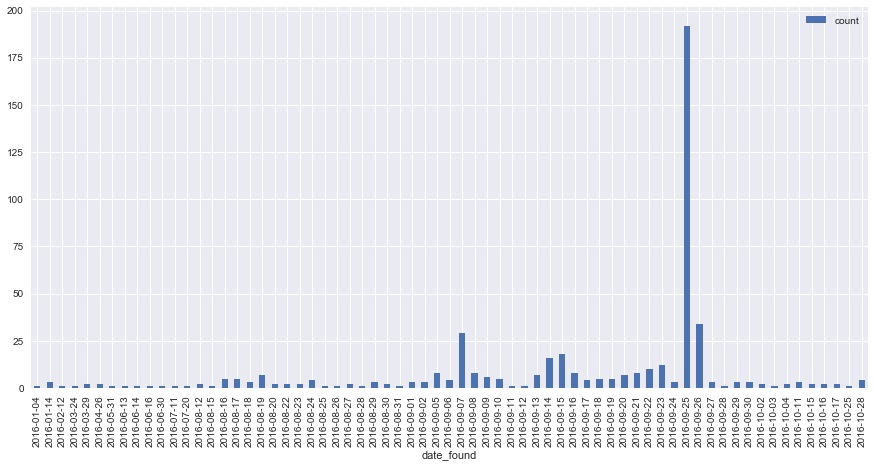

In [5]:
# Here, a time plot of the number of tweets mentionning #LRens (votation of the 25 sept 2016)

from datetime import datetime

date_parser = lambda d: datetime.strptime(d[:10], "%Y-%m-%d").date()
tweets['date_found'] = tweets['date_found'].apply(date_parser)
counts = pd.DataFrame({"count": tweets.groupby('date_found').size()})
plt.figure()
counts.plot(kind='bar', figsize=(15, 7))

In [6]:
# Dumb test to see the relevance of a dirt simple classifier (to classify tweets into "will vote YES/NO")

noes = ["non", "nein", "no"] 
yess = ['oui', 'ya', 'yes']

no_tweets = []
yes_tweets = []

for i,c in tweets.iterrows():
    comparable = c['main'].lower().split()
    if any([no in comparable for no in noes]):
        print("NO:  ", c['main'], c['tags'])
        no_tweets.append(c['main'])
    if any([yes in comparable for yes in yess]):
        print("YES: ", c['main'], c['tags'])
        yes_tweets.append(c['main'])

NO:   S'il vous plaît les Romands, ALLEZ VOTEZ #LRens NON ! - La participation ne décolle toujours pas à Genève http://www.tdg.ch/23435487  via @tdgch ['lrens']
YES:  Toutes les générations pour AVS+ OUI le 25 septembre ! #ahvplusja #ahvplus #geneve #lrens #économieverte #25septembre2016 #votations ['votations', 'lrens', '25septembre2016', 'ahvplus', 'geneve', 'économieverte', 'ahvplusja']
NO:   .@JCVPSchweiz disent NON à #économieverte & #AVSplus, OUI à #lrens! Chaque fois avec une écrasante majorité #chvotepic.twitter.com/cIO9pLAsqS ['chvote', 'économieverte', 'avsplus', 'lrens']
YES:  .@JCVPSchweiz disent NON à #économieverte & #AVSplus, OUI à #lrens! Chaque fois avec une écrasante majorité #chvotepic.twitter.com/cIO9pLAsqS ['chvote', 'économieverte', 'avsplus', 'lrens']
NO:   N’oubliez pas de dire NON à la #Lrens https://www.lrens.ch/  et qques points intéressants à lire par @FCharlethttps://francoischarlet.ch/2016/quelques-points-noirs-de-la-lrens/ … ['lrens']
YES:  Pour toutes le

### The exploration that made us a bit skeptical of basing our analysis on the sentiment score... 

First we can see that there are less than 5% of the tweets that aren't classified as "NEUTRAL" which is quite a low number to base our observations on (especially if there isn't much data to begin with). Then, by looking at the tweets we have, it's easy to see – as humans – that the subject is polarizing and there are subtleties and references to History that are hard to pickup by a computer. Example:
  "@benoitgaillard ouais, on a vu, le sujet des écoutes allemandes a été fort bien traité avant la votation sur #LRens -.-"

In [7]:
print(tweets['sentiment'].value_counts())

for idx, t in tweets[tweets['sentiment'] == 'NEUTRAL'].iterrows():
    print(t['main'])

NEUTRAL     450
POSITIVE     12
NEGATIVE      5
Name: sentiment, dtype: int64
Lorsqu'on confond vitesse et précipitation, on prend souvent des décisions erronées #LRens http://www.rts.ch/la-1ere/programmes/forum/7591278-des-elus-pdc-reclament-l-application-en-urgence-de-la-loi-sur-les-renseignements-29-03-2016.html?rts_source=rss_a …
Il faut savoir qu'avec les chevaux de Troie, la #LRens baisse la sécurité des Suisses http://www.rts.ch/la-1ere/programmes/forum/7591278-des-elus-pdc-reclament-l-application-en-urgence-de-la-loi-sur-les-renseignements-29-03-2016.html?rts_source=rss_a …
S'il vous plaît les Romands, ALLEZ VOTEZ #LRens NON ! - La participation ne décolle toujours pas à Genève http://www.tdg.ch/23435487  via @tdgch
@smetille @derBeauftragte Yay continuons dans les solutions privé et closed source... Avec la #LRens , #whatcouldgowrong ? @RTSinfo La Confédération passe à #windows10 dès 2017 alors que l'enquête du @derBeauftragte est toujours en cours! http://www.bit.admin.ch/dok

## Computing the sentiments

In [8]:
i = 0
poscount, negcount = 0, 0
datasets = ['data/harvest3r_twitter_data_30-10_0.json', 'data/harvest3r_twitter_data_31-10_0.json', 'data/harvest3r_twitter_data_01-09_0.json']#glob.glob('data/harvest3r_twitter_data_*.json')
for datapath in datasets:
    i += 1
    print("Working on file {} of {}: {}".format(i, len(datasets), datapath))
    tweets = pd.DataFrame( pd.read_json(datapath)._source.tolist() )
    tweets = tweets.dropna(subset=['sentiment'])
    pos_tweets = tweets[tweets.sentiment == 'POSITIVE']
    neg_tweets = tweets[tweets.sentiment == 'NEGATIVE']
    print("Amount of POSITIVE tweets found: {}".format(pos_tweets.size))
    print("Amount of NEGATIVE tweets found: {}".format(neg_tweets.size))
    poscount += pos_tweets.size
    negcount += neg_tweets.size
    pospath = 'data/pos_' + splitext(basename(datapath))[0] + '.json'
    negpath = 'data/neg_' + splitext(basename(datapath))[0] + '.json'
    print("Positive tweets written to: {}".format(pospath))
    print("Negative tweets written to: {}".format(negpath))
    pos_tweets.to_json(pospath)
    neg_tweets.to_json(negpath)
    
print("Ratio positive/negative: {}/{}".format(poscount, negcount))

Working on file 1 of 3: data/harvest3r_twitter_data_30-10_0.json
Amount of POSITIVE tweets found: 1370144
Amount of NEGATIVE tweets found: 658658
Positive tweets written to: data/pos_harvest3r_twitter_data_30-10_0.json
Negative tweets written to: data/neg_harvest3r_twitter_data_30-10_0.json
Working on file 2 of 3: data/harvest3r_twitter_data_31-10_0.json
Amount of POSITIVE tweets found: 1459068
Amount of NEGATIVE tweets found: 698232
Positive tweets written to: data/pos_harvest3r_twitter_data_31-10_0.json
Negative tweets written to: data/neg_harvest3r_twitter_data_31-10_0.json
Working on file 3 of 3: data/harvest3r_twitter_data_01-09_0.json
Amount of POSITIVE tweets found: 874736
Amount of NEGATIVE tweets found: 401488
Positive tweets written to: data/pos_harvest3r_twitter_data_01-09_0.json
Negative tweets written to: data/neg_harvest3r_twitter_data_01-09_0.json
Ratio positive/negative: 3703948/1758378


In [9]:
print("# Positive tweets set")
pos_train_tweets_30 = pd.read_json('data/pos_harvest3r_twitter_data_30-10_0.json')
pos_train_tweets_31 = pd.read_json('data/pos_harvest3r_twitter_data_31-10_0.json')
print("Sizes of 30 ({}) and 31 ({})".format(pos_train_tweets_30.main.size, pos_train_tweets_31.main.size))
print("Expected size: {}".format(pos_train_tweets_30.size + pos_train_tweets_31.size))
pos_train_tweets = pos_train_tweets_30.append(pos_train_tweets_31, ignore_index=True)
print("Final size: {}".format(pos_train_tweets.main.size))

print("# Negative tweets set")
neg_train_tweets_30 = pd.read_json('data/neg_harvest3r_twitter_data_30-10_0.json')
neg_train_tweets_31 = pd.read_json('data/neg_harvest3r_twitter_data_31-10_0.json')
print("Sizes of 30 ({}) and 31 ({})".format(neg_train_tweets_30.size, neg_train_tweets_31.size))
print("Expected size: {}".format(neg_train_tweets_30.size + neg_train_tweets_31.size))
neg_train_tweets = neg_train_tweets_30.append(neg_train_tweets_31, ignore_index=True)
print("Final size: {}".format(neg_train_tweets.main.size))

print("# Full tweets set")
train_tweets = pos_train_tweets.append(neg_train_tweets, ignore_index=True)
print("Final size: {}".format(train_tweets.main.size))

print("# Test tweets set")
pos_test_tweets = pd.read_json('data/pos_harvest3r_twitter_data_01-09_0.json')
neg_test_tweets = pd.read_json('data/neg_harvest3r_twitter_data_01-09_0.json')
test_tweets = pos_test_tweets.append(neg_test_tweets, ignore_index=True)
print("Final size: {}".format(test_tweets.main.size))

# Positive tweets set
Sizes of 30 (14576) and 31 (15522)
Expected size: 2829212
Final size: 30098
# Negative tweets set
Sizes of 30 (658658) and 31 (698232)
Expected size: 1356890
Final size: 14435
# Full tweets set
Final size: 44533
# Test tweets set
Final size: 13872


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
#from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score


vectorizer = TfidfVectorizer()
vectorized_train_tweets = vectorizer.fit_transform(train_tweets.main)
classifier = SGDClassifier(loss='modified_huber', penalty='l2', alpha=2e-06, n_jobs=-1)
model = classifier.fit(vectorized_train_tweets, train_tweets.sentiment)
print("Cross validation: ", np.mean(cross_val_score(classifier, vectorized_train_tweets, train_tweets.sentiment, cv=5, n_jobs=-1)))

vectorized_test_tweets = vectorizer.transform(test_tweets.main)
test_tweets['our_sentiment'] = model.predict(vectorized_test_tweets)
accuracy_score(test_tweets.sentiment, test_tweets.our_sentiment)

/home/cranium/.anaconda3/envs/ada/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/cranium/.anaconda3/envs/ada/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Cross validation:  0.951541695002


0.91320645905420994

In [11]:
import datetime as dt

date2week = lambda y, m, d: int(dt.date(y, m, d).strftime('%W'))
date_parser = lambda d: dt.datetime.strptime(d[:10], "%Y-%m-%d").date()

tags = ['abst16', 'lrens', 'rbi']
tweets_by_tags = dict()
votation_dates = { 'abst16': date2week(2016, 11, 27), 'lrens': date2week(2016, 9, 25), 'rbi': date2week(2016, 6, 5) }

for tag in tags:
    tweets = pd.read_json('data/tweets-{}.json'.format(tag))
    vectorized_tweets = vectorizer.transform(tweets.main)
    tweets['date_found'] = tweets.date_found.apply(date_parser)
    tweets['our_sentiment'] = model.predict(vectorized_tweets)
    tweets.votation_week = votation_dates[tag]
    tweets_by_tags[tag] = tweets
    for (id, t) in tweets[['main', 'our_sentiment']].head(10).iterrows():
        print("{}: {}".format(t.our_sentiment, t.main))

POSITIVE: Habt ihr jetzt extra für diese Meldung einen Twitter-Account eingerichtet? @moninielsen @EVP_Thunstetten #DSINein #abst16
POSITIVE: Gotthard-Duell: E-Mail-Kampagne nach US-Vorbild soll für Umschwung sorgen @schweiz_sonntag @2roehren_nein #abst16 https://epaper-fi.azmedien.ch/Nachrichten/06-nar-gotthard-p673587.html?uid=f77e4beb-6236-4ab5-99d8-57d3f6b24dce&Edition=MZS01AZG1 …
POSITIVE: @claudelongchamp Beteiligungszahlen aus ländlichen Gemeinden hat wohl niemand zusammengetragen? (Abgesehen von GE globo) @cloudista #abst16
POSITIVE: Watson-Kommentar zum #NDG: Ein Nein ermöglicht eine bessere Lösung! http://www.watson.ch/Schweiz/Kommentar/474326567-Der-Staat-braucht-gleich-lange-Spiesse-wie-die-Terroristen-%E2%80%93-aber-das-NDG-ist-der-falsche-Weg … #abst16 #NDGNein @watson_news @NDG_nein @NDGnein
POSITIVE: Am 5. Juni ist es so weit, @MBorn77! Merci für die Unterstützung! @MilchkuhJa #Milchkuhinitiative #abst16 https://twitter.com/MBorn77/status/709704809088225281 … Und wann s

#lrens: 487
#rbi: 409
#abst16: 3711


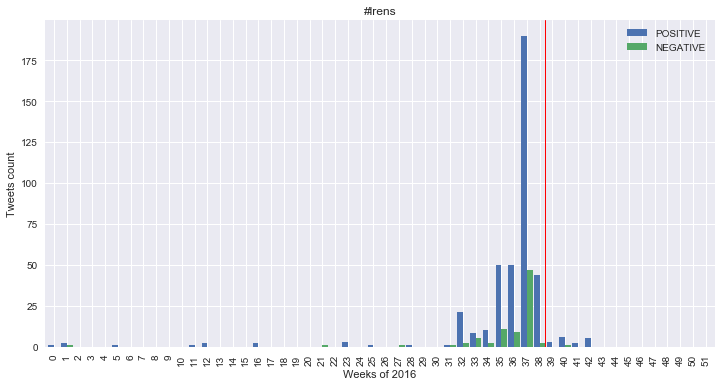

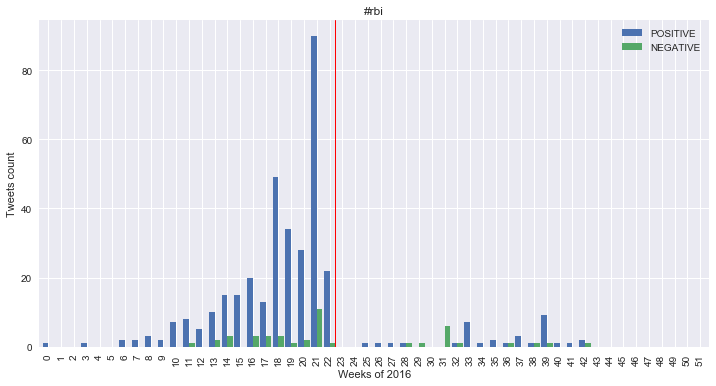

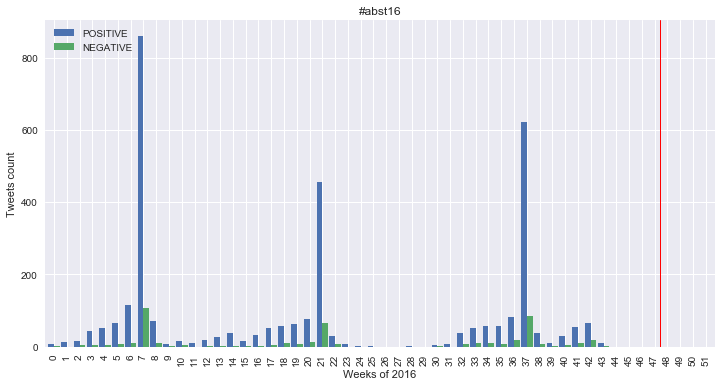

In [12]:
for tag, tweets in tweets_by_tags.items():
    print("#{}: {}".format(tag, tweets.main.size))
    hists = {}
    tweets['week_found'] = tweets.date_found.apply(lambda d: int(d.strftime('%W')))
    for sentiment, data in tweets.groupby('our_sentiment'):
        hist = np.histogram(data.week_found, bins=52, range=[1, 52])
        hists[sentiment] = hist[0]
        index = hist[1][1:]

    pd.DataFrame(hists, columns=['POSITIVE', 'NEGATIVE']).plot.bar(figsize = (12, 6), width = .9)
    plt.axvline(tweets.votation_week + 0.45, color='red', linewidth=1)
    
    plt.title('#' + tag)
    plt.xlabel('Weeks of 2016')
    plt.ylabel('Tweets count')

# Swiss maps generation

Using folium and swiss topo JSON, on the same model as the 3rd homework. We used data from https://www.bk.admin.ch/ch/f/pore/va/20160925/can607.html & https://www.bk.admin.ch/ch/f/pore/va/20160605/can601.html for the votation results.

## Helper functions

In [311]:
# Parses the result of a table copied from admin.ch. 
# Ex: https://www.bk.admin.ch/ch/f/pore/va/20160925/can607.html 
def parse_votation(filename):
    def line_to_result(l):
        # Format is "Canton	Electeurs	Votants	% Particip.	Oui	Non	% Oui	% Non"
        res = {}
        l = l.replace("'", "")
        l = l.replace('%', '')
        l = l.split('\t')
        res['Canton'] = l[0]
        res['Electeurs'] = int(l[1])
        res['Votants'] = int(l[2])
        res['Oui'] = int(l[4])
        res['Non'] = int(l[5])
        return res
    
    with open(filename,'r') as f:
        votation = []
        for l in f.readlines():
            res = line_to_result(l)
            # Skip the aggregated results for "Suisse"
            if res['Canton'] == 'Suisse':
                continue
            
            res['Abbr'] = cantons[res['Canton']]
            votation.append(res)
        return votation
        
# Return a dict from abbr -> prop, to use for the map
def votation_to_dict(votation, prop):
    return { cantons[c['Canton']]: c[prop] for c in votation }

def votation_to_dataframe(votation):
    df = pd.DataFrame(votation)
    df.index = df['Abbr']
    return df

In [312]:
# Load topology
swiss_topo = json.load(open('topojson/ch-cantons.topojson.json'))
cantons = { c['properties']['name']: c['id'] for c in swiss_topo['objects']['cantons']['geometries']}

# Add missing data coming from tweets
cantons['Valais'] = 'VS'
cantons['Geneva'] = 'GE'
cantons['Bern'] = 'BE'
cantons['Zurich'] = 'ZH'

# Add missing data coming from admin.ch
cantons['Berne'] = 'BE'
cantons['Lucerne'] = 'LU'
cantons['Obwald'] = 'OW'
cantons['Nidwald'] = 'NW'
cantons['Glaris'] = 'GL'
cantons['Zoug'] = 'ZG'
cantons['Soleure'] = 'SO'
cantons['Bâle-Ville'] = 'BS'
cantons['Bâle-Campagne'] = 'BL'
cantons['Schaffhouse'] = 'SH'
cantons['Appenzell Rhodes-Ext.'] = 'AR'
cantons['Appenzell Rhodes-Int.'] = 'AI'
cantons['Saint-Gall'] = 'SG'
cantons['Grisons'] = 'GR'
cantons['Argovie'] = 'AG'
cantons['Thurgovie'] = 'TG'
cantons['Tessin'] = 'TI'

cantons_df = pd.DataFrame.from_dict(cantons, orient='index')
cantons_df.columns = ['abbr']

### Code to discover missing values:
#to_add = set()
#for n in tweets.geo_state.values:
#    if not n in cantons and not n in to_add:
#        to_add.add(n)
#        print(n)

In [313]:
cantons

{'Aargau': 'AG',
 'Appenzell Ausserrhoden': 'AR',
 'Appenzell Innerrhoden': 'AI',
 'Appenzell Rhodes-Ext.': 'AR',
 'Appenzell Rhodes-Int.': 'AI',
 'Argovie': 'AG',
 'Basel-Landschaft': 'BL',
 'Basel-Stadt': 'BS',
 'Bern': 'BE',
 'Bern/Berne': 'BE',
 'Berne': 'BE',
 'Bâle-Campagne': 'BL',
 'Bâle-Ville': 'BS',
 'Fribourg': 'FR',
 'Geneva': 'GE',
 'Genève': 'GE',
 'Glaris': 'GL',
 'Glarus': 'GL',
 'Graubünden/Grigioni': 'GR',
 'Grisons': 'GR',
 'Jura': 'JU',
 'Lucerne': 'LU',
 'Luzern': 'LU',
 'Neuchâtel': 'NE',
 'Nidwald': 'NW',
 'Nidwalden': 'NW',
 'Obwald': 'OW',
 'Obwalden': 'OW',
 'Saint-Gall': 'SG',
 'Schaffhausen': 'SH',
 'Schaffhouse': 'SH',
 'Schwyz': 'SZ',
 'Soleure': 'SO',
 'Solothurn': 'SO',
 'St. Gallen': 'SG',
 'Tessin': 'TI',
 'Thurgau': 'TG',
 'Thurgovie': 'TG',
 'Ticino': 'TI',
 'Uri': 'UR',
 'Valais': 'VS',
 'Valais/Wallis': 'VS',
 'Vaud': 'VD',
 'Zoug': 'ZG',
 'Zug': 'ZG',
 'Zurich': 'ZH',
 'Zürich': 'ZH'}

## LRens

In [337]:
# Load our tweets for LRens
tweets = pd.read_json('data/tweets-lrens.json')
vectorized_tweets = vectorizer.transform(tweets.main)
tweets['our_sentiment'] = model.predict(vectorized_tweets) # add computed sentiment

geo_tweets = tweets.copy()
geo_tweets = geo_tweets.join(cantons_df, on=['geo_state',], how='inner')

tweet_counts = geo_tweets.groupby(by='abbr').size()
tweets_per_canton = tweet_counts.to_dict()

# Compute the percentage of positive tweets over the total
positive_score = geo_tweets.groupby(by='abbr')['our_sentiment'].apply(lambda x: x[x == 'POSITIVE'].count()/x.count())

In [338]:
votation = parse_votation('votations_results/lrens.txt')
votation_df = votation_to_dataframe(votation)

swiss_map = fol.Map(location = [46.8, 8.33], tiles = 'Mapbox Bright', zoom_start = 7)

votation_df['tweetsPer1kVotants'] = (tweet_counts / votation_df['Votants']).fillna(0) * 1000
votants_scale = np.linspace(votation_df['tweetsPer1kVotants'].min(), votation_df['tweetsPer1kVotants'].max(),6).tolist()

swiss_map.choropleth(
    geo_data = swiss_topo, topojson = "objects.cantons",
    legend_name = 'Tweets about LRens per thousand of voters', name='Tweets per 1k voters',
    data = votation_df['tweetsPer1kVotants'], key_on = 'feature.id', fill_opacity = 1, line_opacity = 1,
    fill_color = 'YlOrRd', threshold_scale = votants_scale)

counts = tweets_per_canton.values()
qscale = tweet_counts.quantile([0, 0.5, 0.75, 0.85, 0.95, 1]).tolist()

swiss_map.choropleth(
    geo_data = swiss_topo, topojson = "objects.cantons",
    legend_name = 'Tweets about LRens', name = 'Number of tweets',
    data = tweets_per_canton, key_on = 'feature.id', fill_opacity = 1, line_opacity = 1,
    fill_color = 'YlOrRd', threshold_scale = qscale)

fol.LayerControl(collapsed=False).add_to(swiss_map)

swiss_map.save('maps/lrens_tweets.html')
swiss_map

In [339]:
swiss_map = fol.Map(location = [46.8, 8.33], tiles = 'Mapbox Bright', zoom_start = 7)

linscale = np.linspace(0, 1, 6).tolist()
votescale = np.linspace(0.3, 0.7, 5).tolist()
votation_df['Oui%'] = votation_df['Oui'] / votation_df['Votants']

swiss_map.choropleth(
    geo_data = swiss_topo, topojson = "objects.cantons",
    legend_name = 'Positivity in tweets about LRens', name = 'Tweets',
    data = positive_score, key_on = 'feature.id', fill_opacity = 1, line_opacity = 1,
    fill_color = 'YlGn', threshold_scale = linscale)

swiss_map.choropleth(
    geo_data = swiss_topo, topojson = "objects.cantons",
    legend_name = 'Results of the votation for LRens', name = 'Results',
    data = votation_df['Oui%'], key_on = 'feature.id', fill_opacity = 1, line_opacity = 1,
    fill_color = 'RdYlGn', threshold_scale = votescale)

fol.LayerControl(collapsed=False).add_to(swiss_map)

swiss_map.save('maps/lrens_sentiment.html')
swiss_map

### RBI

In [340]:
# Load our tweets for RBI
tweets = pd.read_json('data/tweets-rbi.json')
vectorized_tweets = vectorizer.transform(tweets.main)
tweets['our_sentiment'] = model.predict(vectorized_tweets) # add computed sentiment

geo_tweets = tweets.copy()
geo_tweets = geo_tweets.join(cantons_df, on=['geo_state',], how='inner')

tweet_counts = geo_tweets.groupby(by='abbr').size()
tweets_per_canton = tweet_counts.to_dict()

# Compute the percentage of positive tweets over the total
positive_score = geo_tweets.groupby(by='abbr')['our_sentiment'].apply(lambda x: x[x == 'POSITIVE'].count()/x.count())

In [341]:
votation = parse_votation('votations_results/rbi.txt')
votation_df = votation_to_dataframe(votation)

swiss_map = fol.Map(location = [46.8, 8.33], tiles = 'Mapbox Bright', zoom_start = 7)

votation_df['tweetsPer1kVotants'] = (tweet_counts / votation_df['Votants']).fillna(0) * 1000
votants_scale = np.linspace(votation_df['tweetsPer1kVotants'].min(), votation_df['tweetsPer1kVotants'].max(),6).tolist()

swiss_map.choropleth(
    geo_data = swiss_topo, topojson = "objects.cantons",
    legend_name = 'Tweets about RBI per thousand of voters', name='Tweets per 1k voters',
    data = votation_df['tweetsPer1kVotants'], key_on = 'feature.id', fill_opacity = 1, line_opacity = 1,
    fill_color = 'YlOrRd', threshold_scale = votants_scale)

counts = tweets_per_canton.values()
qscale = tweet_counts.quantile([0, 0.5, 0.75, 0.85, 0.95, 1]).tolist()

swiss_map.choropleth(
    geo_data = swiss_topo, topojson = "objects.cantons",
    legend_name = 'Tweets about RBI', name = 'Number of tweets',
    data = tweets_per_canton, key_on = 'feature.id', fill_opacity = 1, line_opacity = 1,
    fill_color = 'YlOrRd', threshold_scale = qscale)

fol.LayerControl(collapsed=False).add_to(swiss_map)

swiss_map.save('maps/rbi_tweets.html')
swiss_map

In [342]:
swiss_map = fol.Map(location = [46.8, 8.33], tiles = 'Mapbox Bright', zoom_start = 7)

linscale = np.linspace(0, 1, 6).tolist()
votescale = np.linspace(0.3, 0.7, 5).tolist()
votation_df['Oui%'] = votation_df['Oui'] / votation_df['Votants']

swiss_map.choropleth(
    geo_data = swiss_topo, topojson = "objects.cantons",
    legend_name = 'Positivity in tweets about RBI', name = 'Tweets',
    data = positive_score, key_on = 'feature.id', fill_opacity = 1, line_opacity = 1,
    fill_color = 'YlGn', threshold_scale = linscale)

swiss_map.choropleth(
    geo_data = swiss_topo, topojson = "objects.cantons",
    legend_name = 'Results of the votation for RBI', name = 'Results',
    data = votation_df['Oui%'], key_on = 'feature.id', fill_opacity = 1, line_opacity = 1,
    fill_color = 'RdYlGn', threshold_scale = votescale)

fol.LayerControl(collapsed=False).add_to(swiss_map)

swiss_map.save('maps/rbi_sentiment.html')
swiss_map